In [1]:
import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config, Simulation
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

## Parameters

#### Lorenz attractor simulation parameters

We simulate here 9 different possible Lorenz attractor configurations, essentially modifying the parameter $r$ that governs the behavior of the system. 

As a reminder, here is how the behavior of the system is affected by the parameter $r$:

- $0<r<1$ : 1 stable attractor
- $1<r<\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 2 stable attractors
- $r>\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 3 unstable attractors

For each of the three cases above, we chose to take 3 Lorenz configurations. For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

In [2]:
config = load_config('config.yaml')

# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']
orders = config['simulations']['order']

## Simulation

Here we simulate all possible Lorenz traces according to the parameters mentioned above

In [3]:
simulations = []
for condition in lorenz_parameters:
    for i in range(len(lorenz_parameters[condition])):
        sim = Simulation(num_samples, num_steps, dt)
        pattern = lorenz_parameters[condition][i]
        sim.simulation_lorenz(pattern)
        simulations.append(sim)

In [4]:
simulations

In [5]:
simulations[0].simulation.shape

(100, 10000, 3)

In [6]:
# create new simulations average list which contains average each element of simulations over first dimension
simulations_average = []
for i in range(len(simulations)):
    average_sim = np.mean(simulations[i].simulation, axis=0)
    simulations_average.append(np.broadcast_to(average_sim, (num_samples, num_steps,3)))

## Visualization

Visualization of one of the $200$ possible initializations for each of the nine possible Lorenz configurations

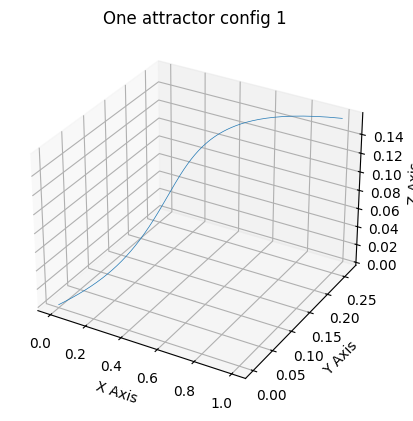

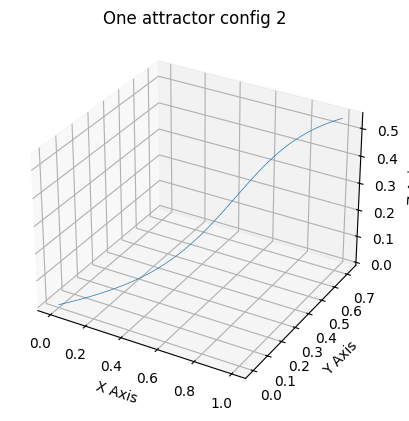

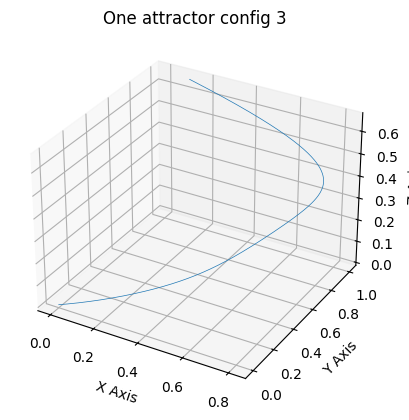

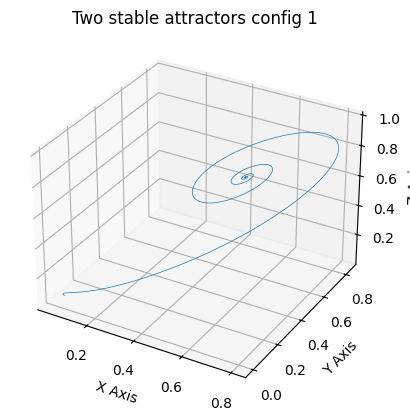

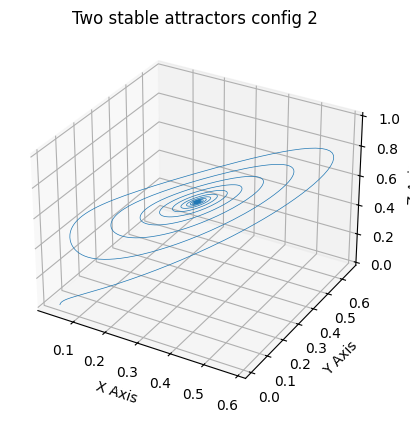

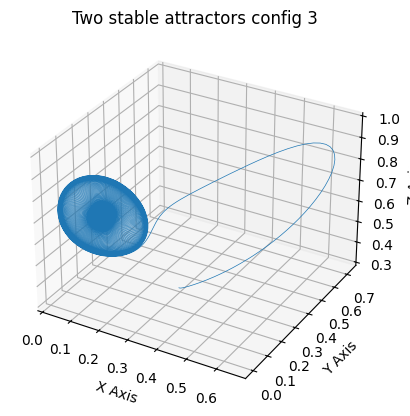

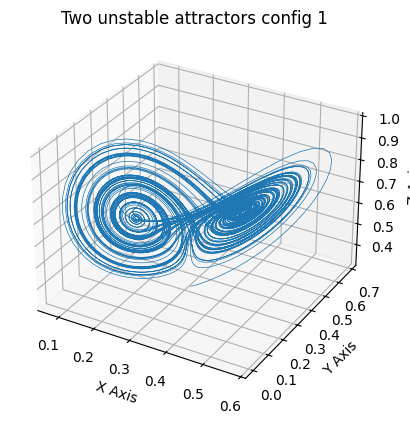

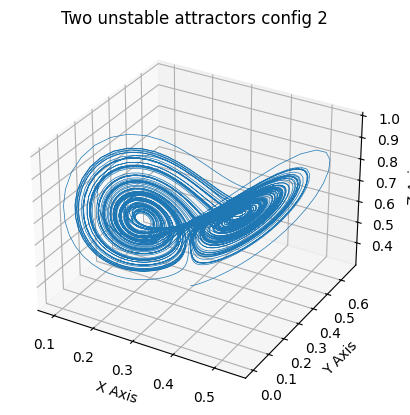

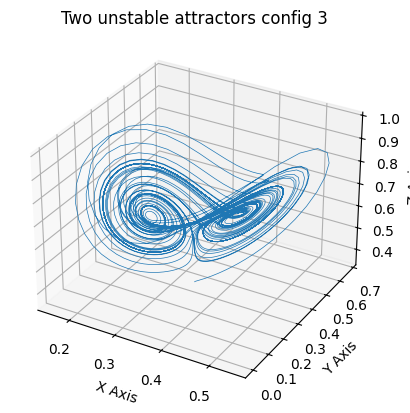

In [7]:
model = [simulations[i].simulation[50,:,:] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])
   plt.savefig(f'data/{model_names[i]}.png')
   plt.show()
   

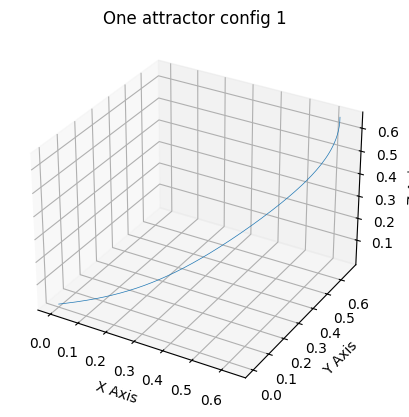

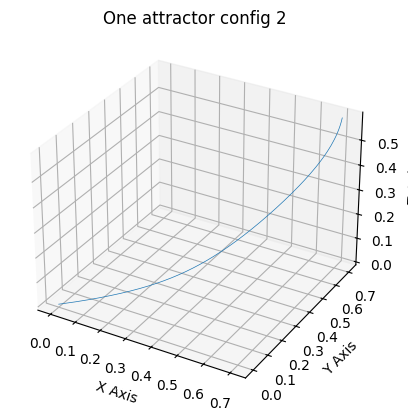

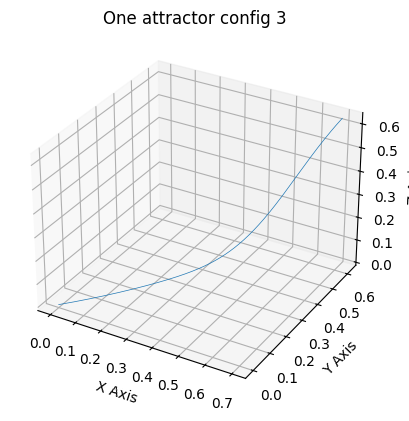

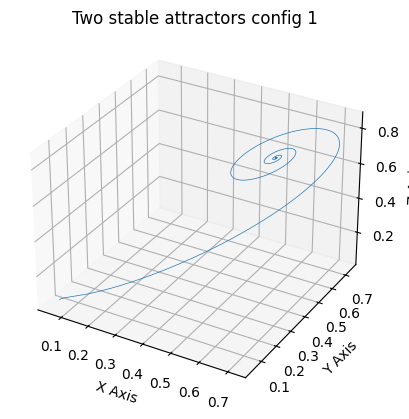

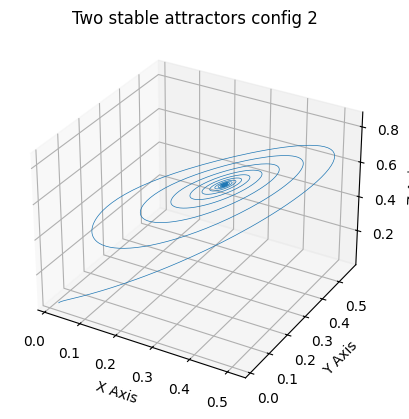

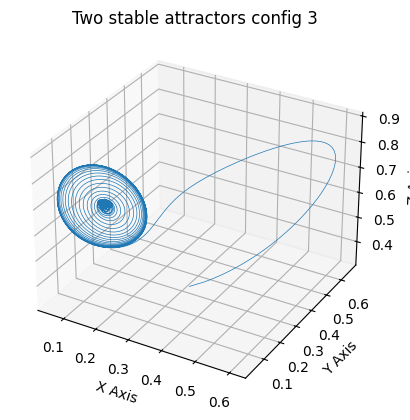

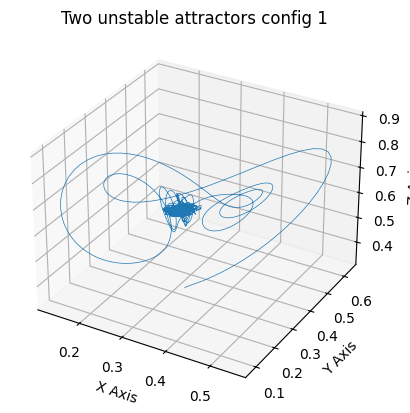

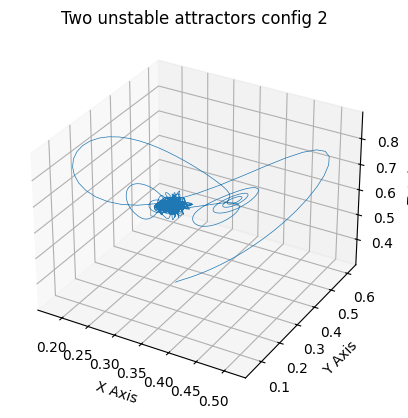

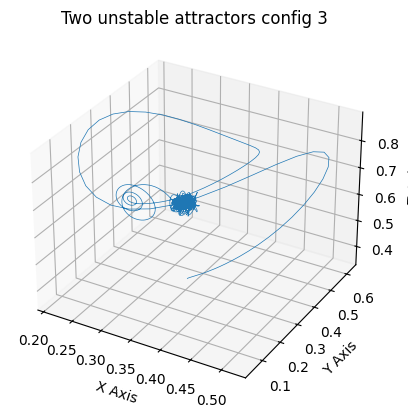

In [8]:
model = [simulations_average[i][50,:,:] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])

   plt.show()

## DSA analysis

Computations of the similarity metric between each of the 9 possible configurations, according to [1]

In [9]:
conditions_average_procrustes = {}

In [10]:
model = [simulations[i].simulation for i in range(9)]

In [14]:
procrustes_measure = similarity.make("measure.sim_metric.cka-angular-score")

In [15]:
procrustes_measure

In [16]:
procrustes_scores = np.empty((len(model),len(model)))
for i in range(len(model)):
     conditions_average_procrustes[i] = procrustes_measure(model[i], simulations_average[i])
procrustes_scores_normalized = procrustes_scores.copy()
for i in range(len(model)):
    for j in range(len(model)):
        procrustes_scores[i,j] = procrustes_measure(model[i],model[j])
        procrustes_scores_normalized[i,j] = (1-procrustes_measure(model[i],model[j]))/(0.5*(2-conditions_average_procrustes[i]-conditions_average_procrustes[j]))
# procrustes_scores_normalized = procrustes_scores_normalized / np.max(procrustes_scores)
procrustes_scores = 1 - procrustes_scores

arccos score: 0.8394372895079303 0.5745493625842439 0.16056271049206972
arccos score: 0.8580043616255958 0.5394246225530395 0.1419956383744042
arccos score: 0.7864840167241092 0.6657010269455601 0.21351598327589083
arccos score: 0.8217061262236475 0.6063980676149994 0.17829387377635253
arccos score: 0.7849450850426782 0.6681888393843902 0.21505491495732176
arccos score: 0.20920146535680517 1.3600380424683767 0.7907985346431948
arccos score: 0.05122495950821393 1.5195489384404195 0.9487750404917861
arccos score: 0.04900349899396428 1.521773194209872 0.9509965010060357
arccos score: 0.05139709648557966 1.5193765744114252 0.9486029035144203
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.7032483495611319 0.7908400296729762 0.2967516504388681
arccos score: 0.7032483495611319 0.7908400296729762 0.2967516504388681
arccos score: 0.5333166604965301 1.008279792182855 0.46668333950346985
arccos score: 0.5333166604965301 1.008279

In [17]:
conditions_average_procrustes

{0: 0.6342305155776797,
 1: 0.6565916195808155,
 2: 0.5762015637610524,
 3: 0.6139550002307979,
 4: 0.574617773172551,
 5: 0.13417289099253105,
 6: 0.032625100708660204,
 7: 0.03120909550702411,
 8: 0.03273483105756292}

In [18]:
conditions_average_dsa = {}
for i in range(len(model)):
    conditions_average_dsa[i] = DSA.DSA(model[i], simulations_average[i], n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
    conditions_average_dsa[i] = conditions_average_dsa[i].fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAV

In [19]:
dsa = DSA.DSA(model,n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
dsa_scores = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

In [20]:
conditions_average_dsa

{0: 0.4023430347442627,
 1: 0.38664066791534424,
 2: 0.37304696440696716,
 3: 0.3416827917098999,
 4: 0.3143948018550873,
 5: 0.01325583178550005,
 6: 0.011477269232273102,
 7: 0.010113478638231754,
 8: 0.017225541174411774}

In [21]:
dsa_scores_normalized = dsa_scores.copy()
for i in range(len(model)):
    for j in range(len(model)):
        dsa_scores_normalized[i,j] = dsa_scores[i,j]/(0.5*(conditions_average_dsa[i]+conditions_average_dsa[j]))
# dsa_scores_normalized = dsa_scores_normalized / np.max(dsa_scores)

### Heatmap

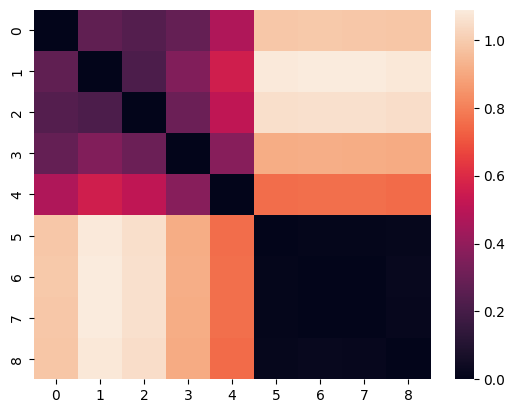

In [22]:
sns.heatmap(dsa_scores)
plt.savefig('data/heatmap_dsa.png')
plt.show()

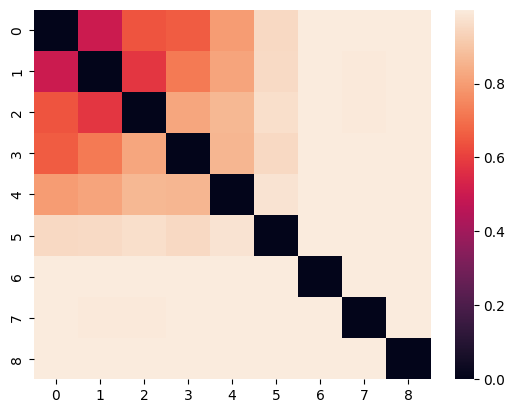

In [27]:
sns.heatmap(procrustes_scores)
plt.savefig('data/heatmap_cka.png')
plt.show()

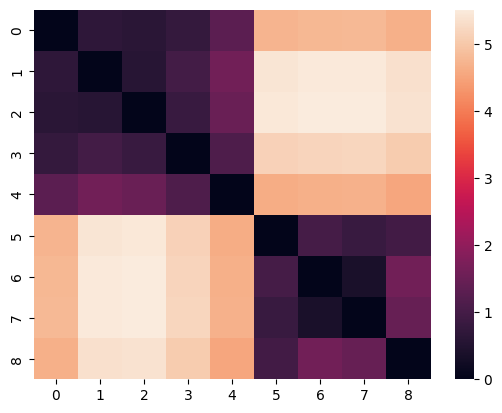

In [24]:
sns.heatmap(dsa_scores_normalized)
plt.show()

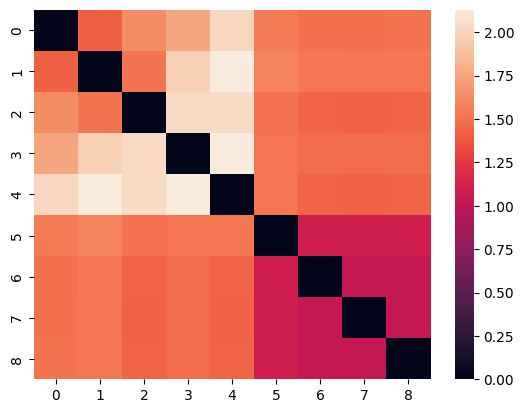

In [25]:
sns.heatmap(procrustes_scores_normalized)
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 